# Objective

We have a monthly time series data of the air passengers from 1 Jan 1949 to 1 Dec 1960. Each row contains the air passenger number for a month of that particular year. Objective is to build a model to forecast the air passenger traffic for future months.

## Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pylab import rcParams
from pmdarima import auto_arima 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES
from statsmodels.tsa.holtwinters import SimpleExpSmoothing as SES

warnings.filterwarnings("ignore")

## Importing the dataset

In [2]:
airline = pd.read_csv('datasets/Time_Series_AirPassengers.csv')
airline

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


## Understanding The Data 

Dataframe 'airline' contains the time series data. 
There are two columns 'Month' and 'Passengers'. 
Month column contains the value of month in that year and passenger column contains the number of air passenger for that particular month.
As you may have noticed 'Month' column datatype is 'Object', so we are going to convert it to 'datetime'
To make plotting easier, we set the index of pandas dataframe 'airline' to the 'Month' column so that it will act as x-axis & Passenger column as y-axis

In [3]:
print('Shape of the data= ', airline.shape)
print('Column datatypes= \n',airline.dtypes)


Shape of the data=  (144, 2)
Column datatypes= 
 Month         object
Passengers     int64
dtype: object


In [4]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
airline.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [6]:
airline.isnull().sum()

Month         0
Passengers    0
dtype: int64

## Useful Functions

In [7]:
def get_airline_data():
    airline = pd.read_csv('datasets/Time_Series_AirPassengers.csv')
    airline.index = pd.to_datetime(airline.Month)
    airline.drop(columns = ['Month'],axis=1, inplace = True)
    return airline

def get_train_test_data():
    df = get_airline_data()
    train_df = df[:'1956-12-01'] #df[:98] 
    test_df = df['1957-01-01':] #df[98:]   
    return train_df, test_df

def validate(test_df, pred_df,var):  # to provide the Evaluation Metrics for a model
    pred_res = pred_df[var]
    test = test_df[var]
    mse = mean_squared_error(pred_res, test)
    rmse = mean_squared_error(pred_res, test, squared=False)
    mae = mean_absolute_error(pred_res, test)
    mape = mean_absolute_percentage_error(pred_res, test)
    print("mse = {:.3f}, rmse = {:.3f}, mae = {:.3f}, mape = {:.3f}". format(mse, rmse, mae, mape))
    return mse, rmse, mae, mape


# we need to make sure that the index is datetime variable
def plot_and_validate(train_df, test_df, pred_df, var):
    train_df[var].plot(label='Train', legend = True, linewidth = 2)
    test_df[var].plot(label='Test', legend = True, linewidth = 2)
    pred_df[var].plot(label='Pred', legend = True, linewidth = 2)
    plt.xlabel('Years')
    plt.ylabel('No of Air Passengers')
    validate(test_df,pred_df, var)

In [8]:
airline = get_airline_data()
airline
type(airline)

pandas.core.frame.DataFrame

In [9]:
train_df, test_df = get_train_test_data()

mse = 0.000, rmse = 0.000, mae = 0.000, mape = 0.000


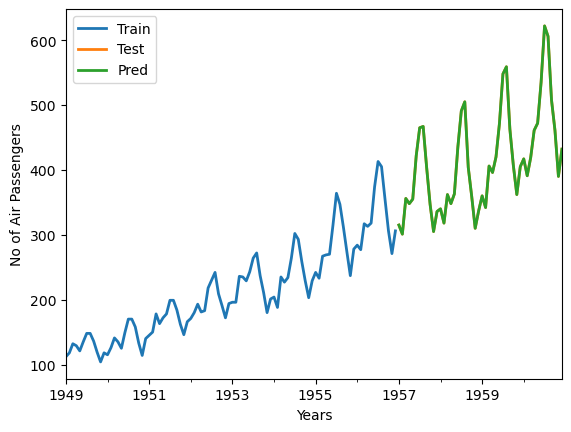

In [10]:
plot_and_validate(train_df, test_df, test_df, 'Passengers')

## Time Series Characteristics

### Trend of Time Series Data

Text(0.5, 1.0, 'Trend of the Time Series')

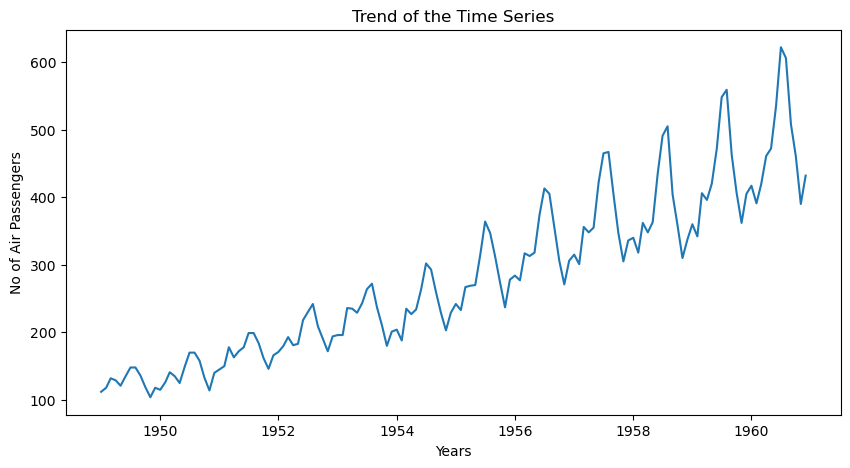

In [11]:
plt.figure(figsize= (10,5))
plt.plot(airline)
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')
plt.title('Trend of the Time Series')

As you can see from above plot there is upward trend of number of passenger for every year.


### Variance
In above graph you can clearly see that the variation is also increasing with the level of the series. You will see in the later part of this exercise how we handle the variance to increase the stationarity of the series.

## SEASONALITY

<AxesSubplot:title={'center':'Seasonality of the Time Series'}, xlabel='Month', ylabel='Passengers'>

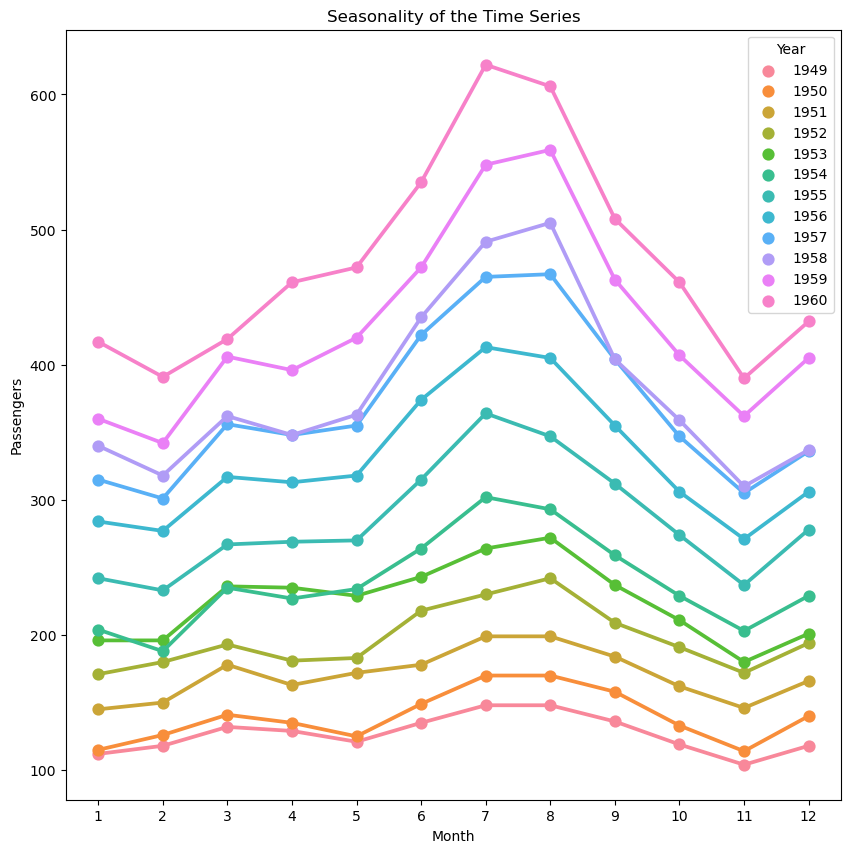

In [12]:
# To plot the seasonality we are going to create a temporary dataframe and add columns for Month and Year values
df_temp = airline.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month
# Stacked line plot
plt.figure(figsize=(10,10))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='Month',y='Passengers',hue='Year',data=df_temp)

From above graph we can say that every year in month of July we observe maximum number of passengers and similarly minimum number of passenger in the month of November.

# Statistical Functions : 

## Decomposition of Time Series

Let's now use the decomposition technique to deconstruct the time series data into several component like trend and seasonality for visualization of time series characteristics.Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data

Trend Component: This is the underlying pattern in the time series that shows the long-term behavior or direction of the data. The trend can be upward, downward, or stationary (no trend).

Seasonal Component: This component shows the regular, recurring fluctuations in the data that occur at fixed intervals. These could be daily, weekly, monthly, quarterly, or yearly. The seasonal component can have a fixed or varying amplitude and phase.

Residual Component: This component captures the noise or randomness in the data that cannot be explained by the trend or seasonal components. It is the difference between the observed value and the predicted value based on the trend and seasonal components.

Here we are going to use 'additive' model because it is quick to develop, fast to train, and provide interpretable patterns.

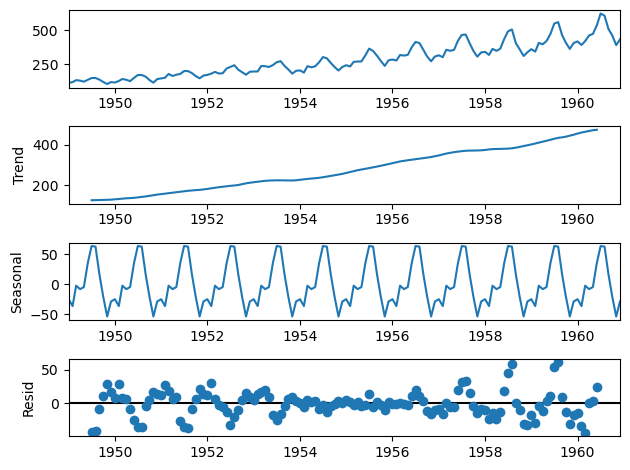

In [13]:
decomposition = sm.tsa.seasonal_decompose(airline, model='additive') 
fig = decomposition.plot()

# FORECASTING Methods

## 1. ARIMA and SARIMA

### 1.1 Test for Stationary

ARIMA models assume that the time series is stationary, and their forecasts are based on the assumption that the statistical properties of the series remain constant over time.

If the time series is not stationary, the model's coefficients may not be accurate, leading to poor forecasting results. 

By identifying and removing non-stationary patterns, we can improve the model's accuracy.

### Augmented Dickey-Fuller (ADF) Test

We can check for stationarity using statistical tests such as the Augmented Dickey-Fuller (ADF) test, which tests whether a time series has a unit root (i.e., a trend) or not. If the ADF test statistic is less than the critical value at a certain significance level(0.05), we can reject the null hypothesis of a unit root and conclude that the time series is stationary. If the ADF test statistic is greater than the critical value, we cannot reject the null hypothesis of a unit root and conclude that the time series is non-stationary.

In [14]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Years')
    plt.ylabel('No of Air Passengers')    
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')   
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test 
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries, autolag = 'AIC')
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

### Differencing

Differencing can be used to remove the trend or seasonality in a non-stationary time series, making it stationary.

Text(0.5, 1.0, 'Different Orders of Differencing')

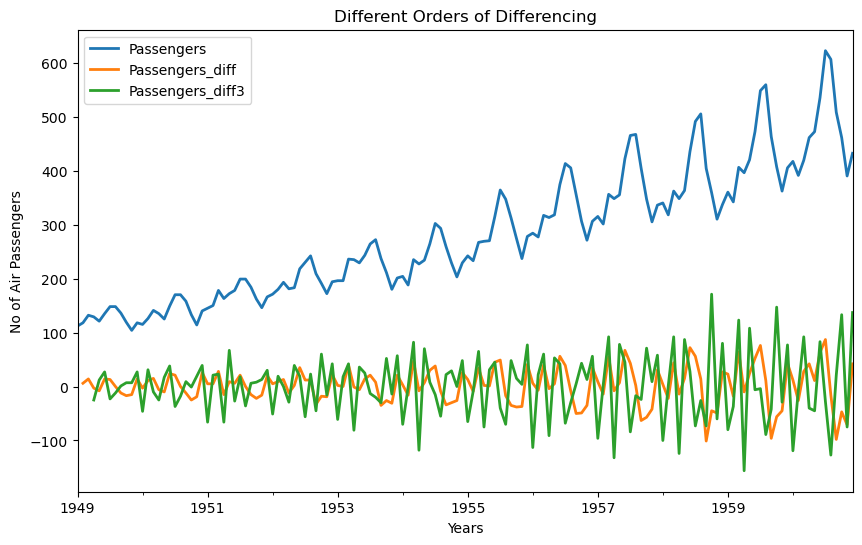

In [15]:
df = get_airline_data()
df['Passengers_diff'] = diff(df['Passengers'],k_diff=1)  # Passengers data with 1 order of differencing
df['Passengers_diff3'] = diff(df['Passengers'],k_diff=3) # Passengers data with 3 order of differencing

df.plot(linewidth=2, figsize = (10,6))
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')
plt.title('Different Orders of Differencing')

Now, we are going to test stationarity of Original Passengers data, Passengers data with 1 order of differencing and Passengers data with 3 order of differencing in order to find out which data is suitable for modeling.

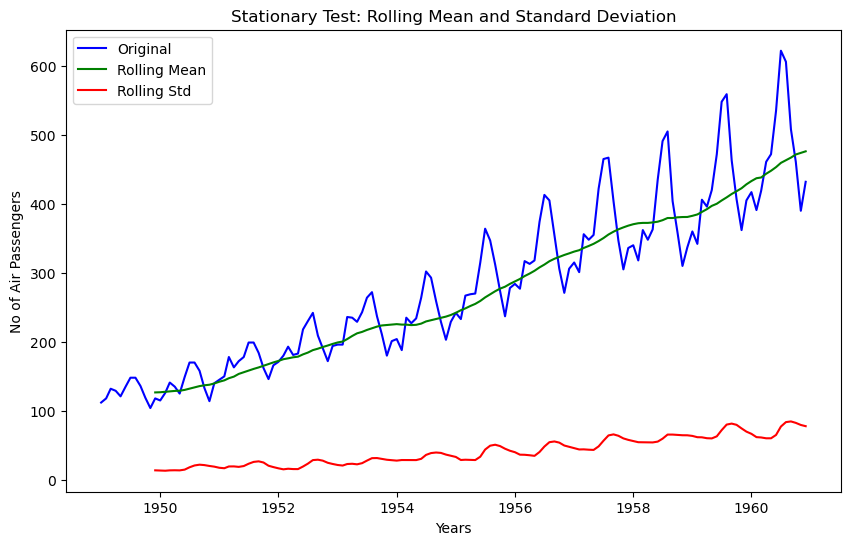

Results of Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [16]:
stationarity_test(df['Passengers'])

For data to be stationary, in Dickey-Fuller Test, p-value <= 0.05. Here, we can see that the p-value is 0.991880.

Hence, original Passengers data is NOT STATIONARY.

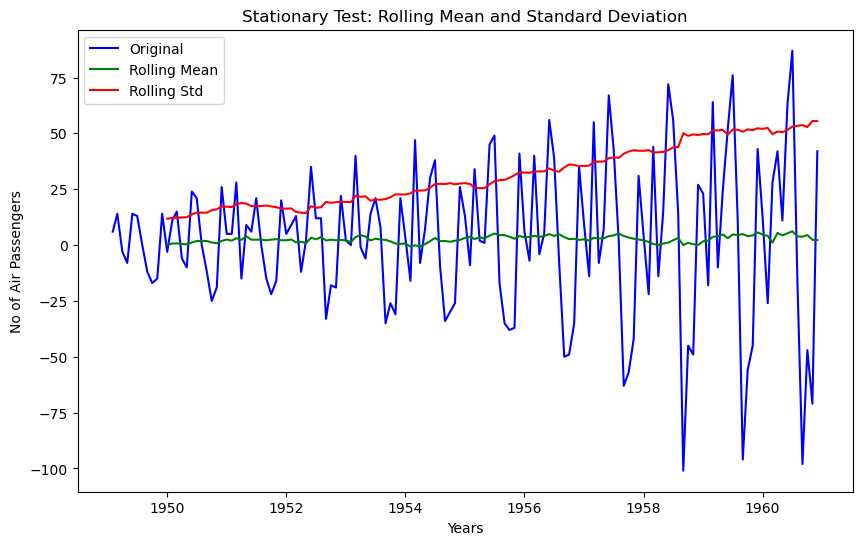

Results of Dickey-Fuller Test
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [17]:
stationarity_test(df['Passengers_diff'].dropna())

For data to be stationary, in Dickey-Fuller Test, p-value <= 0.05. Here, we can see that the P-value is 0.054213.

Hence, Passengers data with 1 order of differencing is NOT STATIONARY.

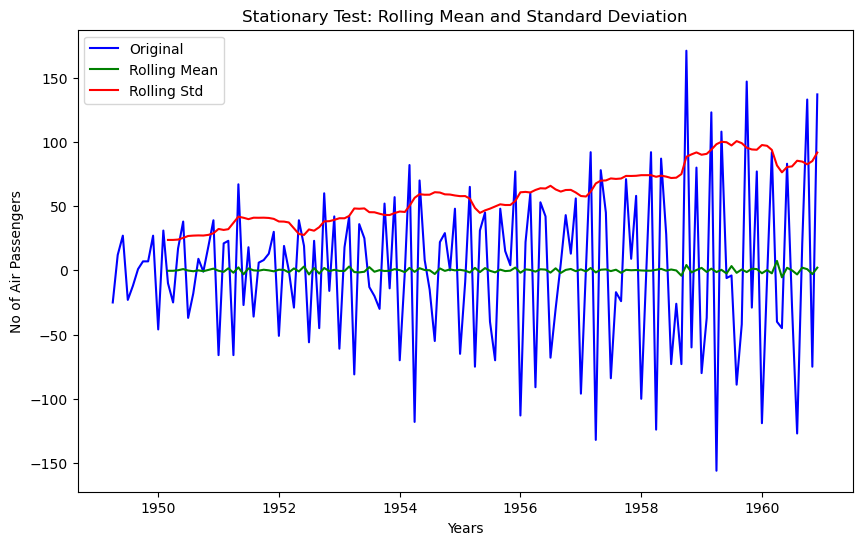

Results of Dickey-Fuller Test
Test Statistic                -9.434675e+00
p-value                        5.079967e-16
#Lags Used                     1.400000e+01
Number of Observations Used    1.260000e+02
Critical Value (1%)           -3.483346e+00
Critical Value (5%)           -2.884766e+00
Critical Value (10%)          -2.579156e+00
dtype: float64


In [18]:
stationarity_test(df['Passengers_diff3'].dropna())

For data to be stationary, in Dickey-Fuller Test, p-value <= 0.05. Here, we can see that the P-value is 5.079967e-16.

Hence, Passengers data with 3 order of differencing is STATIONARY.

### 1.2 ACF and PACF correlation plots

In time series analysis, the Autocorrelation Function (ACF)'q' and the Partial Autocorrelation Function (PACF)'p' are two important tools used to identify the order of the AR (autoregressive) and MA (moving average) terms in an ARIMA (autoregressive integrated moving average) model.

The ACF measures the correlation between a time series and its lagged values. It shows how closely related an observation is to its lagged values, at various lags. The ACF plot displays the correlation coefficients on the y-axis and the lag on the x-axis.

The PACF measures the correlation between a time series and its lagged values, after controlling for the effects of earlier lags. It shows the direct relationship between an observation and its lagged values, excluding the effects of the intermediate lags. The PACF plot displays the correlation coefficients on the y-axis and the lag on the x-axis.

[1.         0.94804734 0.87557484 0.80668116 0.75262542 0.71376997
 0.6817336  0.66290439 0.65561048 0.67094833 0.70271992 0.74324019
 0.76039504 0.71266087 0.64634228 0.58592342 0.53795519 0.49974753
 0.46873401 0.44987066 0.4416288  0.45722376]


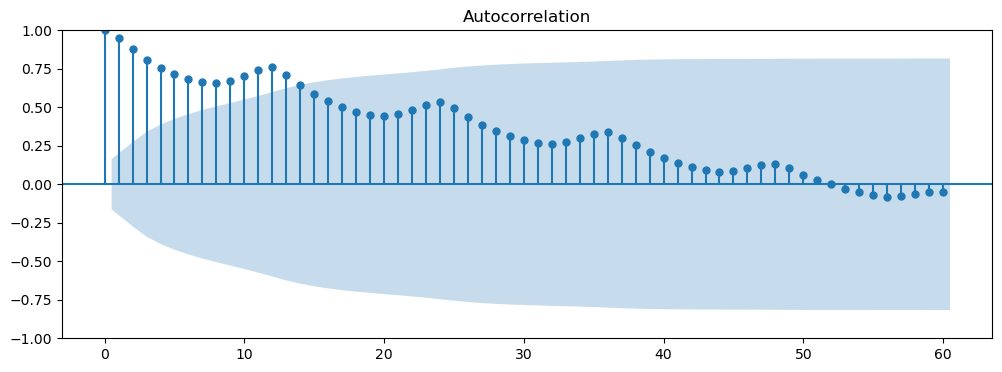

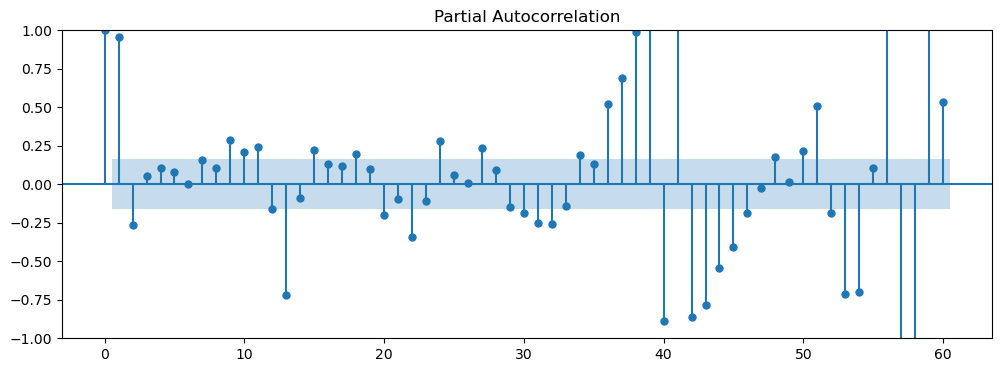

In [19]:
print(acf(df['Passengers']))
rcParams['figure.figsize']  = 12,4
plot_acf(df['Passengers'], lags = 60);
plot_pacf(df['Passengers'], lags = 60);

### 1.3 Auto ARIMA 

This is a time series forecasting algorithm to automate the process of identifying the optimal ARIMA model for a given time series dataset. It uses a stepwise approach to search for the best combination of p, d, and q parameters that minimize the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).

The auto_arima() function takes the time series data as input and returns an ARIMA model that best fits the data.

In [20]:
df = get_airline_data()
model = auto_arima(df['Passengers'], m=12, trace = True, njobs=-1)
print(model)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=2.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.32 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=1.13 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.51 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=1.04 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.26 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.47 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.92 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.85 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=1.81 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.18 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.16 sec
 ARIMA(3,1,1)(0,1,0

## ARIMA

ARIMA (Autoregressive Integrated Moving Average) is a popular and powerful time series forecasting method used to model and predict time series data. It is a combination of autoregressive (AR), integrated (I), and moving average (MA) models.

The ARIMA model is typically denoted as ARIMA(p, d, q), where:

p: The number of autoregressive terms,
d: The number of differences needed to make the time series stationary,
q: The number of moving average terms

mse = 12833.818, rmse = 113.286, mae = 86.696, mape = 0.262


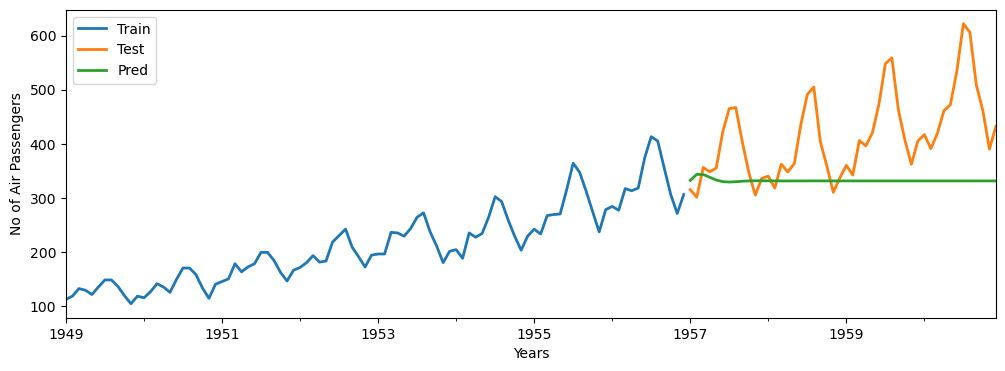

In [21]:
model = ARIMA(train_df['Passengers'],order = (2,1,1)).fit()
predictions = model.predict(start = len(train_df), end = len(df)-1, dynamic = True )
pred_df = predictions.to_frame(name = 'Passengers')
plot_and_validate(train_df,test_df, pred_df, 'Passengers')

As we can see that mape = 0.262 is not so great and moreover the prediction line is a flat line instead of the curvature nature. This is indicating towards the importance of including seasonality factor in our model and not just relying on the trend factor.

## SARIMA

SARIMA stands for Seasonal Autoregressive Integrated Moving Average. It is an extension of the ARIMA model that takes into account seasonality in the data. A SARIMA model includes additional parameters to model the seasonal component of the data, in addition to the parameters for the non-seasonal component.

The SARIMA model is specified by the parameters (p, d, q) for the non-seasonal component, and (P, D, Q, m) for the seasonal component, where m is the number of periods in a season.

mse = 824.636, rmse = 28.716, mae = 20.426, mape = 0.047


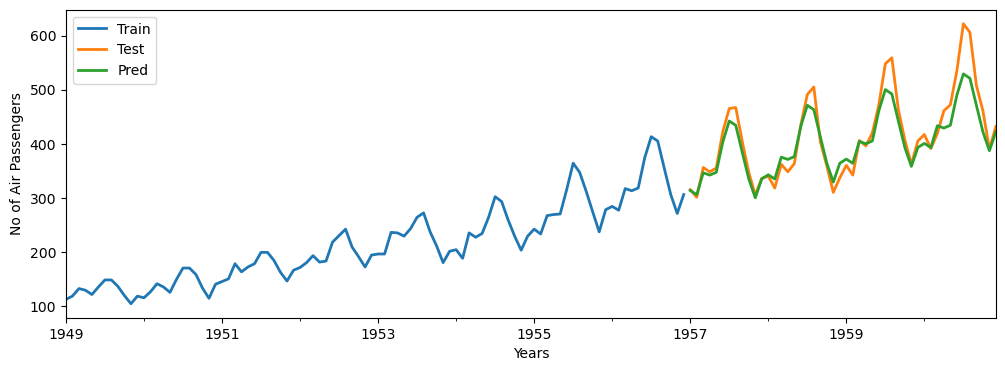

In [22]:
model = SARIMAX(train_df['Passengers'], order = (2,1,1), seasonal_order = (0,1,0,12)).fit()
predictions = model.predict(start = len(train_df), end = len(df)-1)
pred_df = predictions.to_frame(name = 'Passengers')
plot_and_validate(train_df,test_df, pred_df, 'Passengers')

As seen from the results above, SARIMA model results in a pretty good mape of 0.047 and rmse of 28.716. These are clear signs of a really good forecasting model.

## ARIMA (Improved)

Since results from Stationary Tests clearly showed that differencing order of 3 leads to stationary data which even without seasonlity involvement should result in a better forecasting model than the previous ARIMA model. Let's try configuring ARIMA accordingly and observe the results.

mse = 7801.093, rmse = 88.324, mae = 75.126, mape = 0.161


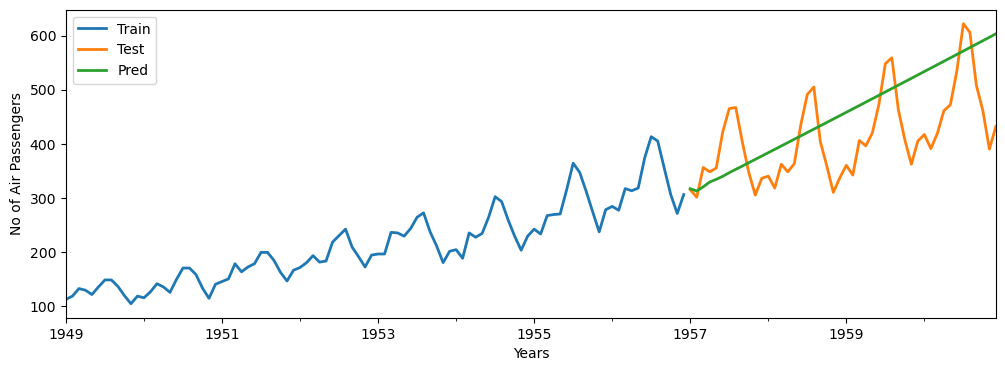

In [23]:
model = ARIMA(train_df['Passengers'],order = (2,3,1)).fit()
predictions = model.predict(start = len(train_df), end = len(df)-1, dynamic = True )
pred_df = predictions.to_frame(name = 'Passengers')
plot_and_validate(train_df,test_df, pred_df, 'Passengers')

As we can see that mape has reduced from 0.262 to 0.161 and moreover the prediction line is a increasing nature of Pred line graph. There is a clear improvement in the performance of the model when dealing from non-stationary data(d=1) to stationary data(d=3).

## 2. Exponential Smoothing

Exponential smoothing is a popular method for smoothing and forecasting time series data. It is based on the idea that the best predictor of the future is a weighted average of past observations, with the weights decreasing exponentially as the observations get older.

There are several types of exponential smoothing, including Simple Exponential Smoothing (SES), Double Exponential Smoothing (DES), and Triple Exponential Smoothing (TES), also known as Holt-Winters Exponential Smoothing.

### 2.1 Simple Exponential Smoothing (SES)

Simple exponential smoothing (SES) is a time series forecasting technique that uses a weighted average of past observations to make predictions for future time periods. 

It is a time series forecasting method for univariate data without a trend or seasonality.

It requires a single parameter, called alpha (a), also called the smoothing factor or smoothing coefficient.

In [24]:
airline = get_airline_data()

In [25]:
span = 12
alpha  = 2/(span+1)
airline['EWMA'] = airline['Passengers'].ewm(alpha = alpha, adjust = False).mean() #Pandas way
airline['EWMA_2'] = SES(airline['Passengers']).fit(smoothing_level=alpha, optimized = False).fittedvalues.shift(-1)
airline.head()


,Passengers,EWMA,EWMA_2
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


ewm() is used for computing Exponential Weighted Moving Average (EWMA) 

Text(0, 0.5, 'No of Air Passengers')

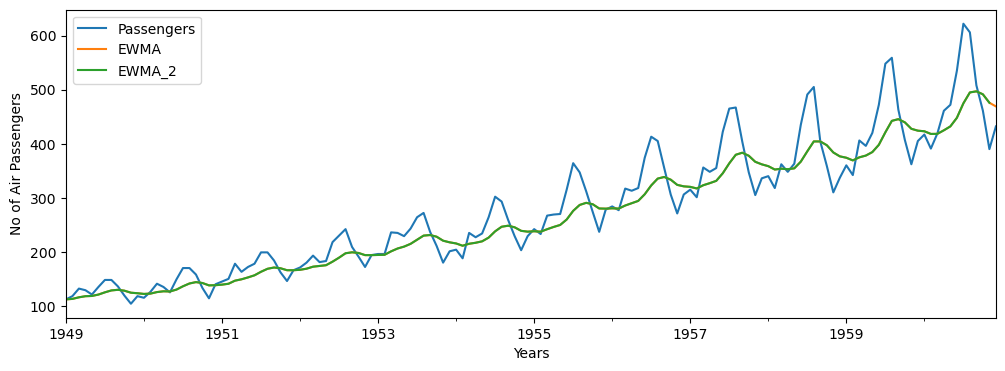

In [26]:
airline[['Passengers','EWMA','EWMA_2']].plot()
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')
#EWMA : Exponential Weight Moving Average

### 2.2 Double Exponential Smoothing (Holts Method)

Double Exponential Smoothing is an extension to Exponential Smoothing that explicitly adds support for trends in the univariate time series.

In addition to the alpha parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend called beta (b).

The method supports trends that change in different ways: an additive and a multiplicative, depending on whether the trend is linear or exponential respectively.

Double Exponential Smoothing with an additive trend is classically referred to as Holt’s linear trend model, named for the developer of the method Charles Holt.

Additive Trend: Double Exponential Smoothing with a linear trend.
Multiplicative Trend: Double Exponential Smoothing with an exponential trend.

,Passengers,EWMA,EWMA_2,DES_add_1,DES_mul_1
Month,,,,,
1949-01-01,112,112.000000,112.000000,114.102394,113.990701
1949-02-01,118,112.923077,112.923077,120.040657,120.031669
1949-03-01,132,115.857988,115.857988,134.001539,134.235979
1949-04-01,129,117.879836,117.879836,131.085845,131.270786
1949-05-01,121,118.359861,118.359861,123.110263,123.156267
...,...,...,...,...,...
1960-08-01,606,494.898619,494.898619,608.168786,616.673652
1960-09-01,508,496.914216,496.914216,510.571382,517.378618
1960-10-01,461,491.388952,491.388952,463.313463,469.290950


Text(0, 0.5, 'No of Air Passengers')

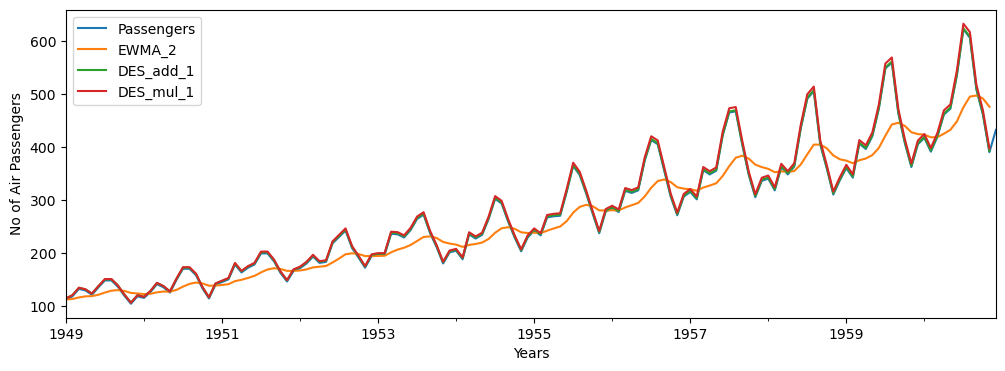

In [27]:
ES_add_model = ES(airline['Passengers'], trend='add')
airline['DES_add_1'] = ES_add_model.fit().fittedvalues.shift(-1) # Additive
ES_mul_model = ES(airline['Passengers'], trend='mul')
airline['DES_mul_1'] = ES_mul_model.fit().fittedvalues.shift(-1) # Multiplicative
display(airline)
airline[['Passengers','EWMA_2','DES_add_1','DES_mul_1']].plot()
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')

### 2.3 Triple Exponential Smoothing (Holts-Winter method)

Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series.

In addition to the alpha and beta smoothing factors, a new parameter is added called gamma (g) that controls the influence on the seasonal component.

As with the trend, the seasonality may be modeled as either an additive or multiplicative process for a linear or exponential change in the seasonality.

Additive Seasonality: Triple Exponential Smoothing with a linear seasonality, 
Multiplicative Seasonality: Triple Exponential Smoothing with an exponential seasonality.

Triple exponential smoothing is the most advanced variation of exponential smoothing and through configuration, it can also develop double and single exponential smoothing models.

,Passengers,EWMA,EWMA_2,DES_add_1,DES_mul_1,TES_add_1,TES_mul_1
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,114.102394,113.990701,120.138781,118.842908
1949-02-01,118,112.923077,112.923077,120.040657,120.031669,134.669157,133.330735
1949-03-01,132,115.857988,115.857988,134.001539,134.235979,131.379385,127.897958
1949-04-01,129,117.879836,117.879836,131.085845,131.270786,124.627330,120.982190
1949-05-01,121,118.359861,118.359861,123.110263,123.156267,140.401591,133.911342
...,...,...,...,...,...,...,...
1960-08-01,606,494.898619,494.898619,608.168786,616.673652,507.657562,511.998458
1960-09-01,508,496.914216,496.914216,510.571382,517.378618,451.326014,448.033463
1960-10-01,461,491.388952,491.388952,463.313463,469.290950,407.931508,397.251316


Text(0, 0.5, 'No of Air Passengers')

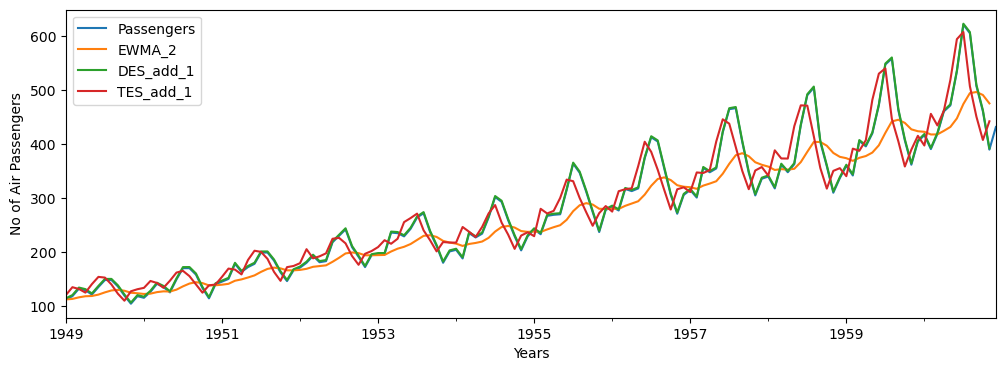

In [28]:
ES_add_model = ES(airline['Passengers'], trend = 'add', seasonal='add', seasonal_periods=12)
airline['TES_add_1'] = ES_add_model.fit().fittedvalues.shift(-1)
ES_mul_model = ES(airline['Passengers'], trend = 'mul', seasonal='mul', seasonal_periods=12)
airline['TES_mul_1'] = ES_mul_model.fit().fittedvalues.shift(-1)
display(airline)
airline[['Passengers', 'EWMA_2', 'DES_add_1','TES_add_1']].plot()
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')

#### A closer look at in a specific time time_period

Text(0, 0.5, 'No of Air Passengers')

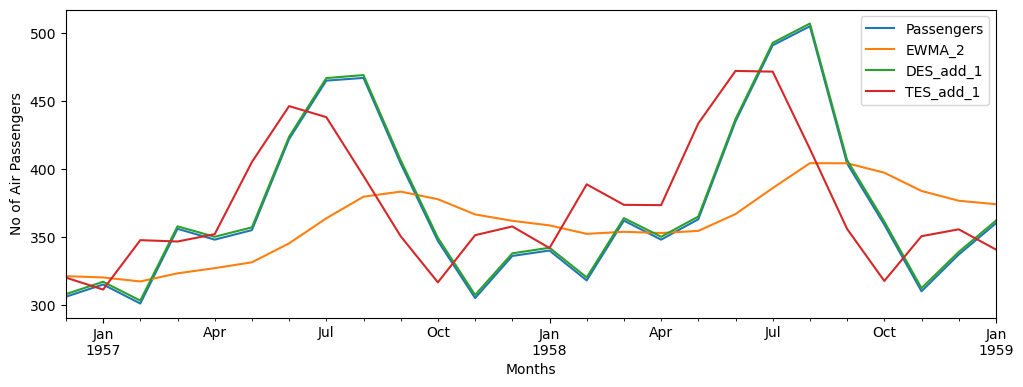

In [29]:
start_dt = '1956-12-01'
end_dt = '1959-01-01'
airline[start_dt:end_dt][['Passengers', 'EWMA_2', 'DES_add_1','TES_add_1']].plot()
plt.xlabel('Months')
plt.ylabel('No of Air Passengers')

### Forescating with Exponential Smoothing

mse = 1017.608, rmse = 31.900, mae = 22.821, mape = 0.053


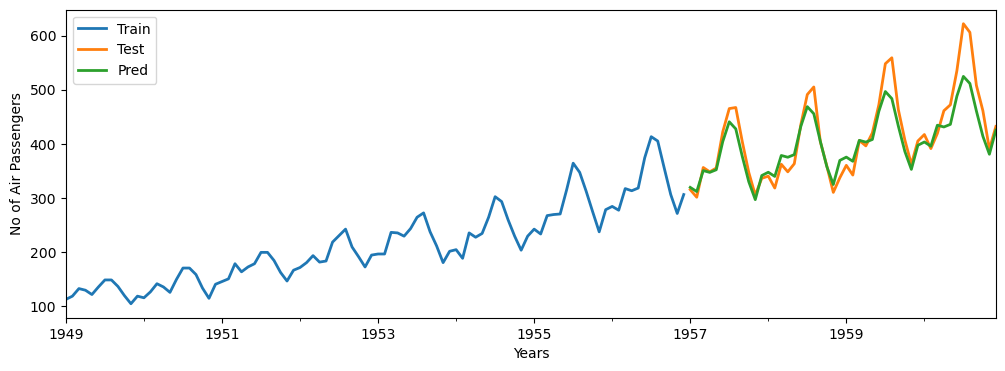

In [30]:
# TES 
ES_model_add = ES(train_df['Passengers'], trend = 'add', seasonal='add', seasonal_periods=12).fit()
pred_add = ES_model_add.forecast(len(test_df))
pred_add_df = pd.DataFrame(pred_add,columns = ['Passengers'])
plot_and_validate(train_df, test_df, pred_add_df, 'Passengers')

As seen from the results above, Exponential Smoothing model results in a pretty good mape of 0.053 and rmse of 31.900. These are clear signs of a really good forecasting model.

# CONCLUSION

| Forecasting Model| RMSE | MAPE |
| -------- | -------- | -------- |
| ARIMA  | 113.286 | 0.262 |
| SARIMA | 28.716 | 0.047 |
| ARIMA(Improved) | 88.324 | 0.161 |
| Exponential Smoothing | 31.900 | 0.053 |

Based, on model evaluating metrics (rmse, mape), SARIMA should be the chosen forecasting model for our data.